In [1]:
import sys

sys.path.append('../')

In [2]:
import json
import os

import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from pytorch_metric_learning.losses import NTXentLoss
from sentence_transformers import SentenceTransformer

from data import SGDDataset, get_dataloader
from model import Embedder
from train import GRUEmbedder, eval_epoch, train_epoch

In [3]:
with open('data/train_ids.json') as train_ids_file:
    train_ids = json.load(train_ids_file)
with open('data/eval_ids.json') as eval_ids_file:
    eval_ids = json.load(eval_ids_file)

train_set = SGDDataset('../dstc8-schema-guided-dialogue', train_ids)
eval_set = SGDDataset('../dstc8-schema-guided-dialogue', eval_ids)

C:\Users\Win_11\PycharmProjects\dialog-similarity\venv\lib\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Augmenting...: 100%|███████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 2936.45it/s]


In [4]:
embeddings_dir = '../conversation-similarity/cache'

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

model_name = 'all-mpnet-base-v2'
model = SentenceTransformer(model_name, device=device)
embedder = Embedder(model=model, tokenizer=None, device=device)

train_set.compute_embeddings(embeddings_dir, embedder, model_name)
eval_set.compute_embeddings(embeddings_dir, embedder, model_name)

del embedder

Computing embeddings...: 100%|██████████████████████████████████████████████████████| 185/185 [00:00<00:00, 223.44it/s]


In [5]:
train_loader = get_dataloader(train_set, batch_size=32, mode='train')
eval_loader = get_dataloader(eval_set, batch_size=32, mode='eval')

model = GRUEmbedder(input_dim=768, hidden_size=64).to(device)
optimizer = torch.optim.AdamW(model.parameters())
criterion = NTXentLoss()

In [6]:
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')

In [7]:
max_epochs = 250
tolerance = 25

logs = {'Epoch': [], 'Loss (train)': [], 'Loss (eval)': []}

best_eval_loss = np.inf
last_update = 0

for epoch in range(max_epochs):

    if last_update > tolerance:
        break
        
    train_loss = train_epoch(
        model=model,
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
    )
    
    eval_loss = eval_epoch(
        model=model,
        dataloader=eval_loader,
        criterion=criterion,
        device=device,
    )
    
    if eval_loss < best_eval_loss:
        last_update = 0
        best_eval_loss = eval_loss
        torch.save(model.state_dict(), checkpoint_path)
    
    last_update += 1
    
    logs['Epoch'].append(epoch + 1)
    logs['Loss (train)'].append(train_loss)
    logs['Loss (eval)'].append(eval_loss)

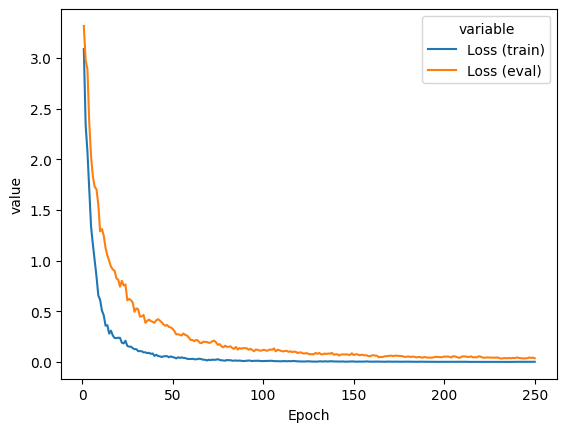

In [8]:
sns.lineplot(
    pd.melt(pd.DataFrame(logs), ['Epoch']),
    x='Epoch',
    y='value',
    hue='variable',
)
plt.show()